### A2.2 LDA y Árboles de Decisión 
Inciso 1

En este primer bloque de código se importó la base de datos A2.2.csv (spotifydataset.csv) y se limpió siguiendo la misma lógica que se usó en el proyecto del primer parcial, con el objetivo de obtener una base de datos que se pueda procesar.

La variable popularity se transformó en una variable binaria con el objetivo de simplificar el problema de clasificación. Para ello, se utilizó la mediana como valor de referencia: si la popularidad de una canción estaba por encima de este valor, se consideró como popular (1), y si estaba por debajo o igual, se clasificó como no popular (0). El uso de la mediana, en lugar del promedio, permitió reducir el impacto de posibles valores atípicos. Una vez realizada la transformación, la variable original popularity fue eliminada del conjunto de datos, conservando únicamente la versión binarizada (popularity_binary).

Al finalizar este paso, se imprimió el head del dataframe para confirmar que los datos estuvieran listos para la fase de modelado.

Con la base de datos procesada, se procedió a dividir los datos tarin y test (80/20). Para ello, se empleó la función train_test_split, configurando el parámetro stratify en relación con la variable popularity_binary. Esto garantizó que la proporción de clases (0 = no popular, 1 = popular) se mantuviera tanto en el conjunto de entrenamiento como en el de prueba, evitando posibles sesgos en la representación de las categorías.

Posteriormente, se calcularon los porcentajes de cada clase (0 y 1) en el dataset original, así como en los subconjuntos de entrenamiento y prueba. Estos resultados confirmaron que la división preservó de manera adecuada la distribución de la variable de salida.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier, plot_tree
%matplotlib inline

# Importar datos
df = pd.read_csv("A2.2.csv")

# Eliminar características no funcionales
df = df.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], axis=1)

# Generar dummies para track_genre
genre_dummies = pd.get_dummies(df['track_genre'], prefix='genre')
df = pd.concat([df, genre_dummies], axis=1)
df = df.drop('track_genre', axis=1)

# Generar variables dummies para key
key_dummies = pd.get_dummies(df['key'], prefix='key')
df = pd.concat([df, key_dummies], axis=1)
df = df.drop('key', axis=1)

# Limitar base de datos canciones de pop
pop_columns = [col for col in df.columns if col.startswith('genre') and 'pop' in col.lower()]
mask = df[pop_columns].any(axis=1)
df = df[mask].reset_index(drop=True)
genre_columns = [col for col in df.columns if col.startswith('genre_')]
df = df.drop(columns=genre_columns)

# Volver True = 1 y False = 0
# Explicit
df['explicit'] = df['explicit'].astype('int8')
# Keys
key_cols = [col for col in df.columns if col.startswith('key_')]
for col in key_cols:
    df[col] = df[col].astype('int8')

# Revisar outliers en duración
q1=df.duration_ms.quantile(0.25)
q3=df.duration_ms.quantile(0.75)
iqr=q3-q1
li=q1-(3*iqr)
ls=q3+(3*iqr)
out=np.where((df.duration_ms<=li) | (df.duration_ms>=ls))[0]
print("Outliers de duración:")
print(df.iloc[out])

# Limitar la duración de canciones entre 60,000 (1 min) - 600,000 (10 min)
df = df[(df['duration_ms'] >= 60000) & (df['duration_ms'] <= 600000)].copy()
df = df.reset_index(drop=True)

# Búsqueda de variables con corelación
cor=abs(np.corrcoef(df,rowvar=False))
np.fill_diagonal(cor,0)
i,j=np.unravel_index(cor.argmax(),cor.shape)
print("Variables con mayor correlación (índices): ",i,j)
print("Variables con mayor correlación (nombre): ", df.columns[i], df.columns[j])
print("Valor de correlación absoluta: ",cor[i,j])
df = df.drop('loudness', axis=1)

# Binarizar popularity con ayuda de la mediana
median_popularity = df['popularity'].median()
print("Mediana de variable popularity: ", median_popularity)
df['popularity_binary'] = (df['popularity'] > median_popularity).astype('int8')
df = df.drop('popularity', axis=1)

# Dataframe final
print("Dataframe final:\n",df.head(10))

# Separación en train y test (80/20)
train, test = train_test_split(df, train_size=0.8, random_state=42, stratify=df['popularity_binary']) 
X_train = train.drop('popularity_binary', axis=1)
Y_train = train['popularity_binary']
X_test = test.drop('popularity_binary', axis=1)
Y_test = test['popularity_binary']

print("Clase 0 (%)")
print("Original: ", (df['popularity_binary'] == 0).mean() * 100)
print("Train: ", (Y_train == 0).mean() * 100)
print("Test: ", (Y_test == 0).mean() * 100)

print("\nClase 1 (%)")
print("Original: ", (df['popularity_binary'] == 1).mean() * 100)
print("Train: ", (Y_train == 1).mean() * 100)
print("Test: ", (Y_test == 1).mean() * 100)

Outliers de duración:
      popularity  duration_ms  explicit  danceability  energy  loudness  mode  \
568           48       758307         0         0.437   0.473    -7.669     1   
689           40       601144         0         0.269   0.338   -12.757     1   
1663          40       548571         0         0.559   0.427   -12.228     1   
2008          66       537653         0         0.372   0.426    -8.421     1   
2992          36       605100         0         0.329   0.410   -11.870     1   
3256          13       946552         0         0.364   0.194   -14.938     1   
3325          54       541346         0         0.403   0.439   -15.154     0   
3468          52       519360         0         0.656   0.810    -7.448     1   
3475          53      3340672         0         0.719   0.466    -9.153     1   
3551          66       537653         0         0.372   0.426    -8.421     1   
3553          49      1613160         0         0.586   0.411   -11.425     1   
3616  

Inciso 2

En este segundo bloque de código se ajustó un modelo de regresión logística mediante la función GLM de la librería statsmodels, considerando la familia Binomial y añadiendo una constante al conjunto de entrenamiento para contemplar el intercepto. Posteriormente, se analizaron los valores z-score obtenidos en el resumen del modelo, con el objetivo de identificar las variables más relevantes en la predicción de la variable de salida. A mayor valor significativo del z score, más significancia tiene la variable. A partir de este criterio, se seleccionaron las dos variables con mayor magnitud en su z-score, y se redujeron los conjuntos de entrenamiento y prueba para conservar únicamente dichas características.

In [2]:
# Regresión logística
X_train_sm = sm.add_constant(X_train)
model = sm.GLM(Y_train, X_train_sm, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

# Obtener las 2 variables con z-score más alto
z_scores = abs(result.tvalues)
z_scores = z_scores.drop('const')
top_2 = z_scores.nlargest(2)

print("\n2 Varibles más relevantes:")
print("1.", top_2.index[0], ": |z-score| =", top_2.iloc[0])
print("2.", top_2.index[1], ": |z-score| =", top_2.iloc[1])

# Reducir dataframe
X_train_reduced = X_train[top_2.index].copy()
X_test_reduced = X_test[top_2.index].copy()

                 Generalized Linear Model Regression Results                  
Dep. Variable:      popularity_binary   No. Observations:                 7177
Model:                            GLM   Df Residuals:                     7153
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4658.6
Date:                Thu, 02 Oct 2025   Deviance:                       9317.2
Time:                        08:11:35   Pearson chi2:                 7.22e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08402
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.4025      0.355  

Inciso 3

En este bloque se ajustó un modelo de Linear Discriminant Analysis (LDA) utilizando las dos variables seleccionadas previamente como predictores. El modelo fue entrenado con el conjunto de entrenamiento reducido (X_train_reduced y Y_train) y posteriormente se realizaron predicciones sobre el conjunto de prueba.

Se obtuvieron dos tipos de predicciones: las probabilidades de pertenecer a cada clase (predict_proba) y las clases finales predichas (predict). Para visualizar los resultados, se imprimieron las primeras 10 observaciones de cada tipo de predicción, lo que permite evaluar de manera rápida la salida del modelo y la asignación de cada instancia a su categoría correspondiente.

Para analizar visualmente la capacidad del modelo LDA de separar las clases, se construyó un scatter plot utilizando las dos variables del conjunto reducido. En este caso, cada punto corresponde a una canción del conjunto de prueba y se colorea de acuerdo con la clase predicha por el modelo: rojo para las canciones clasificadas como no populares (clase 0) y azul para las canciones clasificadas como populares (clase 1).

Probabilidades predichas (primeras 10 observaciones)
[[0.37033819 0.62966181]
 [0.66131881 0.33868119]
 [0.35614542 0.64385458]
 [0.57116168 0.42883832]
 [0.33279312 0.66720688]
 [0.57119134 0.42880866]
 [0.65896174 0.34103826]
 [0.56943271 0.43056729]
 [0.57664333 0.42335667]
 [0.52186305 0.47813695]]

Clases predichas (primeras 10 observaciones)
[1 0 1 0 1 0 0 0 0 0]


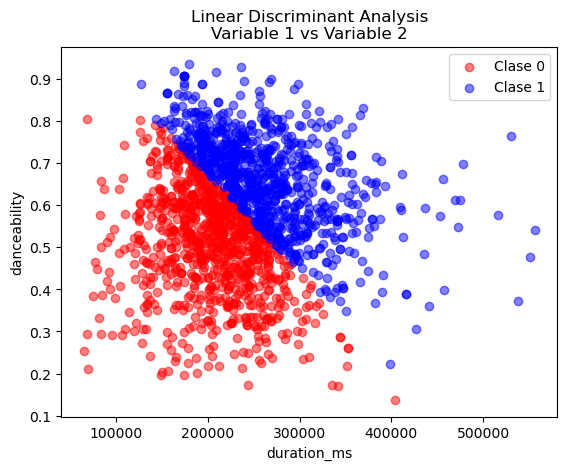

In [3]:
# Modelo LDA
ldaModel = LDA().fit(X_train_reduced, Y_train)
pr = ldaModel.predict_proba(X_test_reduced)
cl = ldaModel.predict(X_test_reduced)

print("Probabilidades predichas (primeras 10 observaciones)")
print(pr[:10])

print("\nClases predichas (primeras 10 observaciones)")
print(cl[:10])

# Graficar 
Y_pred_lda = ldaModel.predict(X_test_reduced)
for clase in [0, 1]:
    mask = (Y_pred_lda == clase)
    color = 'red' if clase == 0 else 'blue'
    plt.scatter(X_test_reduced.loc[mask, X_test_reduced.columns[0]], X_test_reduced.loc[mask, X_test_reduced.columns[1]], c=color, label=f"Clase {clase}", alpha = 0.5)
plt.xlabel(X_train_reduced.columns[0])
plt.ylabel(X_train_reduced.columns[1])
plt.title("Linear Discriminant Analysis\nVariable 1 vs Variable 2")
plt.legend()
plt.show()

Insiso 4

En este bloque se construyó un árbol de decisión completo utilizando las dos variables seleccionadas previamente como predictores. El modelo fue entrenado con el conjunto de entrenamiento reducido (X_train_reduced y Y_train) y se visualizó mediante la función plot_tree. Para evitar sobreajuste, se aplicó la técnica de poda mediante validación cruzada. Se evaluaron distintos valores de ccp_alpha, que controla la fuerza de la poda, generando un conjunto de árboles podados y calculando su desempeño promedio en LOOCV. Sin embargo, debido al tiempo de cómputo, el proceso se migró a k-fold cross-validation con 4 particiones.

Con este procedimiento se identificó el valor de ccp_alpha que proporcionó la mejor puntuación de validación. Finalmente, se construyó el árbol podado utilizando el ccp_alpha óptimo y se volvió a visualizar con plot_tree. El árbol resultante es más compacto y generaliza mejor.

Para evaluar gráficamente el desempeño del árbol de decisión podado, se construyó un scatter plot utilizando las dos variables del conjunto reducido. En esta representación, cada punto corresponde a una canción del conjunto de prueba y se colorea de acuerdo con la clase predicha por el modelo: rojo para las canciones clasificadas como no populares (clase 0) y azul para las canciones clasificadas como populares (clase 1).

ÁRBOL COMPLETO:


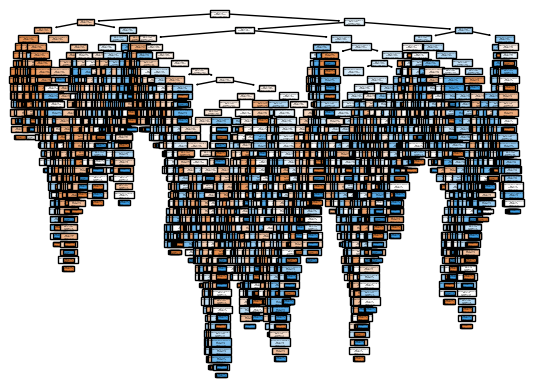

Alpha óptimo:  0.008192771084337351
ÁRBOL PODADO:


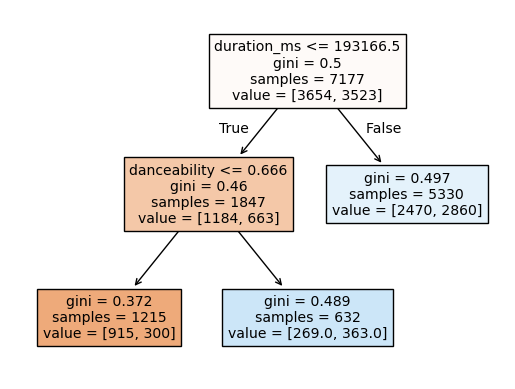

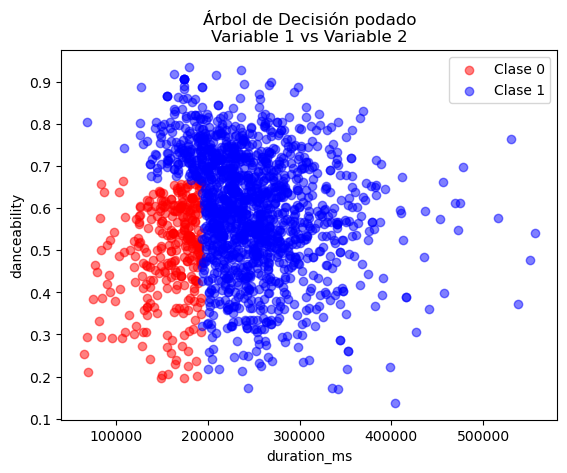

In [4]:
# Árbol completo con las 2 variables
full_tree = DecisionTreeClassifier().fit(X_train_reduced, Y_train)

print("ÁRBOL COMPLETO:")
plot_tree(full_tree, feature_names=X_train_reduced.columns, filled=True)
plt.show()

# K-folds
skf = StratifiedKFold(n_splits=4)
ccp = np.linspace(0.001, 0.2, 250)
cv_scores = []
for alpha in ccp:
      pruned_tree = DecisionTreeClassifier(ccp_alpha=alpha)
      cv_scores.append(np.mean(cross_val_score(pruned_tree, X_train_reduced, Y_train, cv=skf, scoring='f1')))

# Encontrar el mejor alpha
best_alpha = ccp[np.argmax(cv_scores)]
best_score = max(cv_scores)

print("Alpha óptimo: ", best_alpha)

# Árbol podado
pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha).fit(X_train_reduced, Y_train)

print("ÁRBOL PODADO:")
plot_tree(pruned_tree, feature_names=X_train_reduced.columns, filled=True)
plt.show()

# Graficar
Y_pred_tree = pruned_tree.predict(X_test_reduced)
for clase in [0, 1]:
    mask = (Y_pred_tree == clase)
    color = 'red' if clase == 0 else 'blue'
    plt.scatter(X_test_reduced.loc[mask, X_test_reduced.columns[0]],X_test_reduced.loc[mask, X_test_reduced.columns[1]], c=color, label=f"Clase {clase}", alpha=0.5)

plt.xlabel(X_train_reduced.columns[0])
plt.ylabel(X_train_reduced.columns[1])
plt.title("Árbol de Decisión podado\nVariable 1 vs Variable 2")
plt.legend()
plt.show()

Inciso 5

Para comparar el desempeño del modelo de Análisis Discriminante Lineal (LDA) y del Árbol de Decisión podado, se calcularon las principales métricas de clasificación: Accuracy, Recall, Precision, Specificity, F1-Score y AUC. Además, se generaron las matrices de confusión para visualizar los aciertos y errores de clasificación en cada modelo.


LINEAR DISCRIMINANT ANALYSIS
Accuracy:  0.5927576601671309
Precision:  0.5872093023255814
Recall (Sensitivity):  0.5732122587968218
Specificity:  0.611597374179431
F1-Score:  0.5801263641585296
AUC:  0.6205593653521834


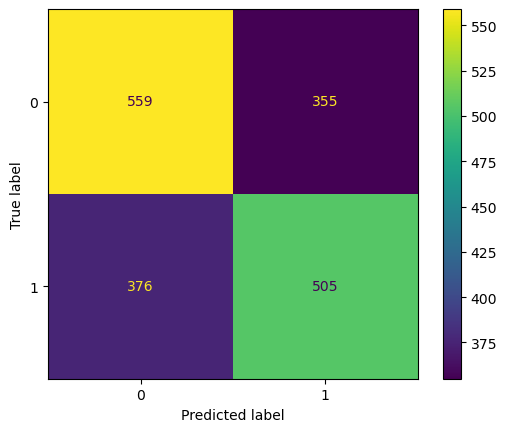


ÁRBOL DE DECISIÓN
Accuracy:  0.5766016713091922
Precision:  0.5411844792375766
Recall (Sensitivity):  0.9023836549375709
Specificity:  0.26258205689277897
F1-Score:  0.676595744680851
AUC:  0.5857440197507806


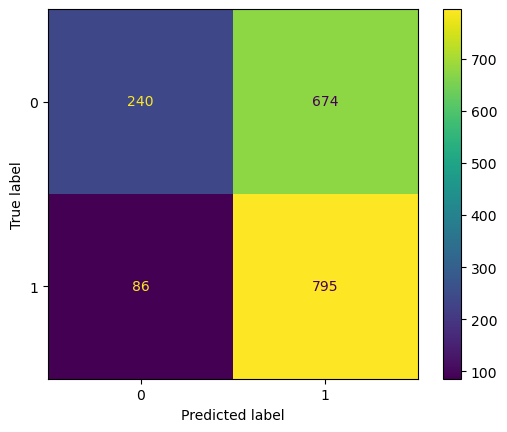

In [5]:
def calculate_specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Métricas LDA
Y_pred_proba_lda = ldaModel.predict_proba(X_test_reduced)[:, 1]
accuracy_lda = accuracy_score(Y_test, Y_pred_lda)
precision_lda = precision_score(Y_test, Y_pred_lda)
recall_lda = recall_score(Y_test, Y_pred_lda) 
f1_lda = f1_score(Y_test, Y_pred_lda)
auc_lda = roc_auc_score(Y_test, Y_pred_proba_lda)
cm_lda = confusion_matrix(Y_test, Y_pred_lda)
specificity_lda = calculate_specificity(cm_lda)

# Métricas Árbol de Decisión
Y_pred_proba_tree = pruned_tree.predict_proba(X_test_reduced)[:, 1]
accuracy_tree = accuracy_score(Y_test, Y_pred_tree)
precision_tree = precision_score(Y_test, Y_pred_tree)
recall_tree = recall_score(Y_test, Y_pred_tree)  
f1_tree = f1_score(Y_test, Y_pred_tree)
auc_tree = roc_auc_score(Y_test, Y_pred_proba_tree)
cm_tree = confusion_matrix(Y_test, Y_pred_tree)
specificity_tree = calculate_specificity(cm_tree)

# Imprimir
print("\nLINEAR DISCRIMINANT ANALYSIS")
print("Accuracy: ", accuracy_lda)
print("Precision: ", precision_lda)
print("Recall (Sensitivity): ", recall_lda)
print("Specificity: ", specificity_lda)
print("F1-Score: ", f1_lda)
print("AUC: ", auc_lda)
ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=ldaModel.classes_).plot()
plt.show()

print("\nÁRBOL DE DECISIÓN")
print("Accuracy: ", accuracy_tree)
print("Precision: ", precision_tree)
print("Recall (Sensitivity): ", recall_tree)
print("Specificity: ", specificity_tree)
print("F1-Score: ", f1_tree)
print("AUC: ", auc_tree)
ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=pruned_tree.classes_).plot()
plt.show()

Comparando ambos modelos se observa que el LDA tiene una exactitud (0.59) ligeramente superior al árbol (0.58) y un mayor poder de discriminación global reflejado en el AUC (0.62 vs 0.59). Su matriz de confusión muestra que logra identificar de forma relativamente balanceada tanto canciones populares como no populares, aunque aún presenta un número considerable de errores. Por su parte, el árbol de decisión podado alcanza un recall mucho más alto (0.90), lo que significa que detecta correctamente la gran mayoría de canciones populares; sin embargo, este resultado se obtiene sacrificando la especificidad, ya que clasifica erróneamente a la mayoría de canciones no populares como populares (674 falsos positivos frente a 240 verdaderos negativos). En términos de F1-Score, el árbol supera al LDA (0.67 vs 0.58) debido a su buen desempeño en la clase positiva, aunque a costa de un sesgo hacia dicha clase. En conclusión, el LDA resulta más útil si se busca un balance entre ambas clases, mientras que el árbol es preferible en contextos donde es más importante no dejar pasar canciones populares, incluso si se incrementan los falsos positivos.